In [ ]:
#%matplotlib inline
#from matplotlib import style
#style.use('fivethirtyeight')


In [1]:
#data science 
#adding some data viz 

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib. pyplot as plt
import seaborn as sns
import datetime
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func



# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [3]:
# INSPECT to get an idea of whats going on with the engine 

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [5]:
# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.measurement'>, <class 'sqlalchemy.ext.automap.station'>]


In [6]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
query = "SELECT max(date) from measurement"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())


[('2017-08-23',)]


In [9]:
#trying in raw sql to see all the data for the date
query = """
    SELECT date, station, prcp
    FROM measurement
    WHERE date = '2016-08-23'
"""

date_df = pd.read_sql(text(query), con = engine)
date_df

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02
5,2016-08-23,USC00519281,1.79
6,2016-08-23,USC00516128,0.70


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
start_date = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
station_year = pd.DataFrame(results,columns = ["Date", "Station", "precipitation"])

# Sort the dataframe by date
station_year["Date"] = pd.to_datetime(station_year['Date'])
station_year = station_year.sort_values(by= "Date", ascending = True).reset_index(drop= True)

# Use Pandas Plotting with Matplotlib to plot the data
station_year.head()

,Date,Station,precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


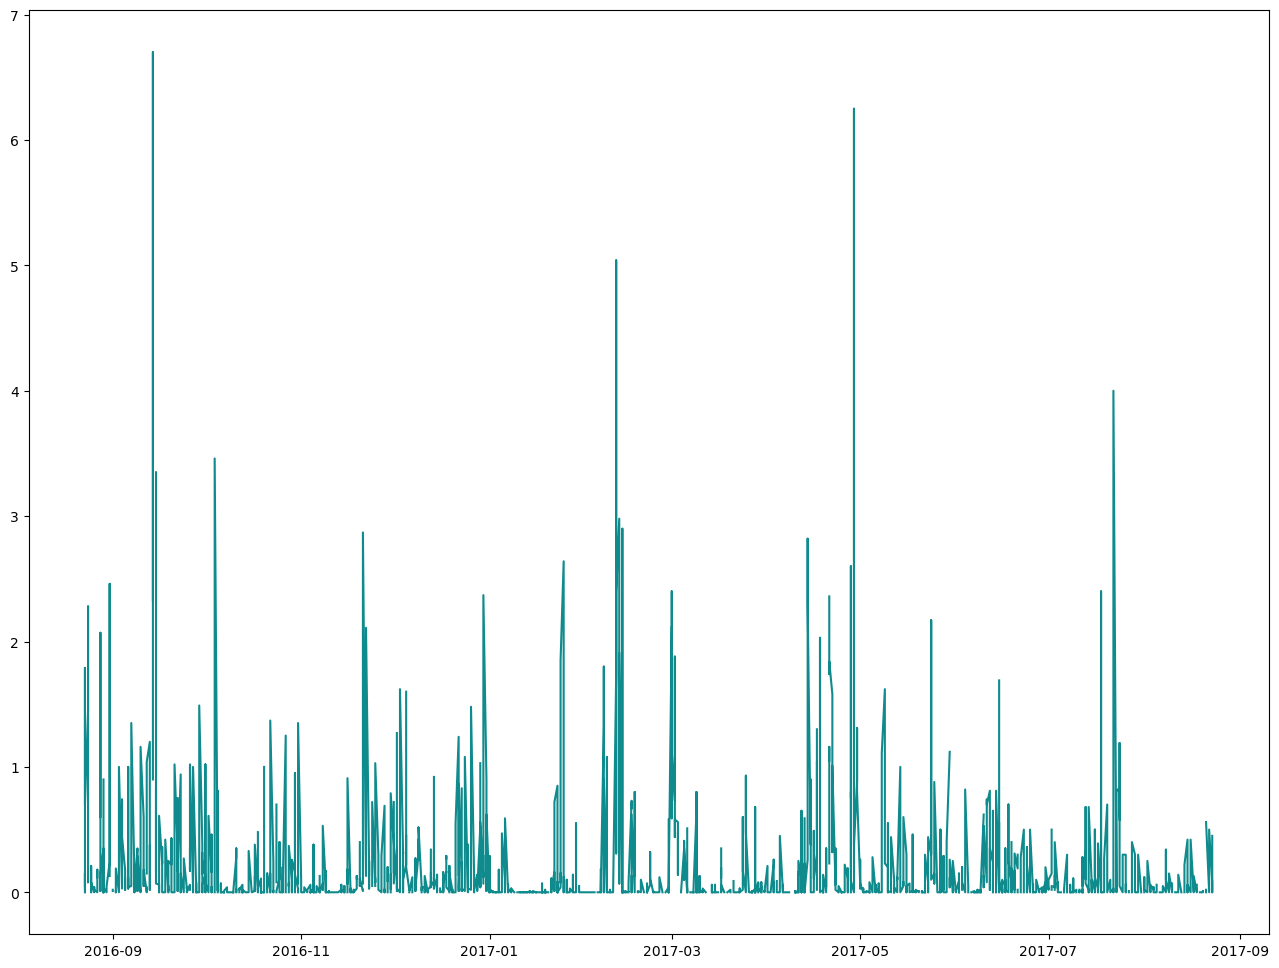

In [18]:
plt.figure(figsize=(16,12))

plt.plot(station_year.Date, station_year.precipitation, color = "#0F8B8D")

plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
station_year.precipitation.describe()


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) FROM station"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[(9,)]


In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = """
    SELECT station, count(*) as num_rows
    FROM measurement
    GROUP BY station
    ORDER BY num_rows desc;
"""
active_stations = pd.read_sql(text(query), con = engine)
active_stations.head()

,station,num_rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
    SELECT min(tobs) as min_temp, avg(tobs) as avg_temp, max(tobs) as max_temp
    FROM measurement
    WHERE station = 'USC00519281';
"""

most_active_station = pd.read_sql(text(query), con=engine)
most_active_station.head()

,min_temp,avg_temp,max_temp
0,54.0,71.663781,85.0


In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = """
    SELECT date,station,tobs
    FROM measurement
    WHERE date >= '2016-08-23' AND station = 'USC00519281'
    ORDER BY date ASC;
"""

most_active_station_temp = pd.read_sql(text(query), con=engine)
most_active_station_temp.head()

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


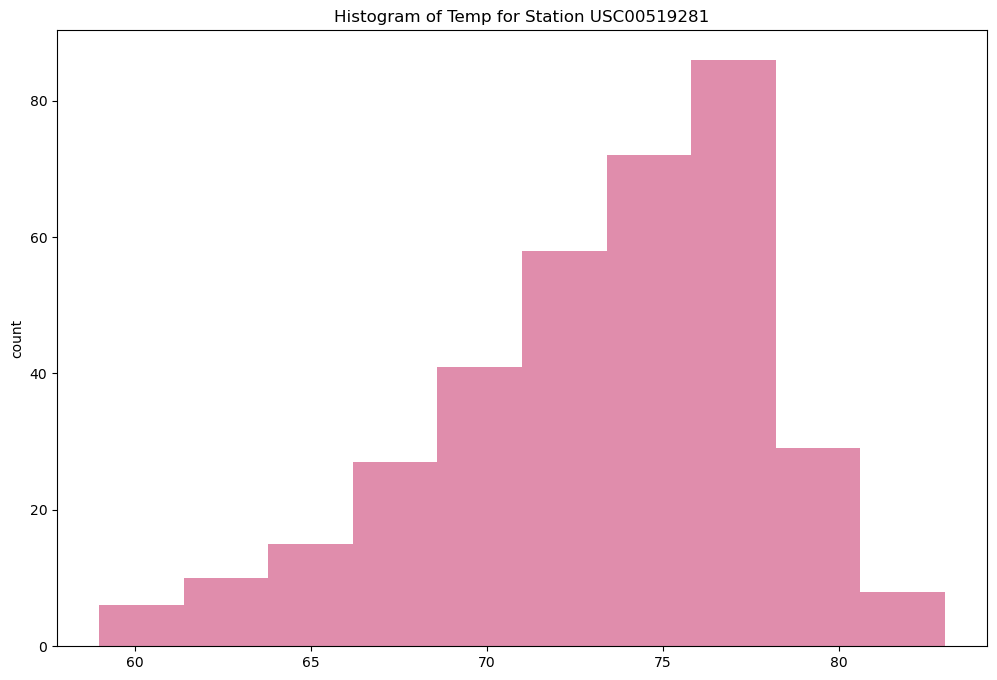

In [35]:
plt.figure (figsize=(12,8))
plt.ylabel("count")
plt.title("Histogram of Temp for Station USC00519281")
plt.hist(most_active_station_temp.tobs, color = "#E08DAC")
plt.show()

# Close Session

In [36]:
# Close Session
session.close()
